In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Jira exploration notebook

### Workflow stages
1. Question or problem definition.
2. Acquire training and testing data.
3. Wrangle, prepare, cleanse the data.
4. Analyze, identify patterns, and explore the data.
5. Model, predict and solve the problem.
6. Visualize, report, and present the problem solving steps and final solution.

### Question and problem definition
Contrary to common belief, the hardest part of data science isn’t building an accurate model or obtaining good, clean data. It is much harder to define feasible problems and come up with reasonable ways of measuring solutions. In agile domain this is not different, our job is make these questions to help teams succeed.

### Workflow goals
The data science solutions workflow solves for seven major goals.

**Classifying**. We may want to classify or categorize our samples. We may also want to understand the implications or correlation of different classes with our solution goal.

**Correlating**. One can approach the problem based on available features within the training dataset. Which features within the dataset contribute significantly to our solution goal? Statistically speaking is there a correlation among a feature and solution goal? As the feature values change does the solution state change as well, and visa-versa? This can be tested both for numerical and categorical features in the given dataset. We may also want to determine correlation among features other than survival for subsequent goals and workflow stages. Correlating certain features may help in creating, completing, or correcting features.

**Converting**. For modeling stage, one needs to prepare the data. Depending on the choice of model algorithm one may require all features to be converted to numerical equivalent values. So for instance converting text categorical values to numeric values.

**Completing**. Data preparation may also require us to estimate any missing values within a feature. Model algorithms may work best when there are no missing values.

**Correcting**. We may also analyze the given training dataset for errors or possibly innacurate values within features and try to corrent these values or exclude the samples containing the errors. One way to do this is to detect any outliers among our samples or features. We may also completely discard a feature if it is not contribting to the analysis or may significantly skew the results.

**Creating**. Can we create new features based on an existing feature or a set of features, such that the new feature follows the correlation, conversion, completeness goals.

**Charting**. How to select the right visualization plots and charts depending on nature of the data and the solution goals.

### Best practices
* Performing feature correlation analysis early in the project.
* Using multiple plots instead of overlays for readability.

In [2]:
#Disable ssl warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# jira dataset and credentials
from getpass import getpass
from jira import JIRA

# data analysis and wrangling
import numpy as np
import pandas as pd
from pandas import DataFrame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

### Acquire data
The Python Pandas packages helps us work with our datasets, Jira packages helps fetching board data from server. We start by acquiring issues and statuses into Pandas DataFrames.

In [14]:
# Retrieve jira credentials
df = pd.read_csv('jiracreds.csv')

jira = JIRA(options={'server': "https://jira.wiley.com/", 'verify': False},
            basic_auth=(df['login'][0], df['pass'][0]))


In [38]:
# Get isse transitions from jira server
def read_data_sets(jql, max_results=10000, status_alias=None):
    if status_alias is None:
        status_alias = {}

    issues = jira.search_issues(jql, maxResults=max_results, expand='changelog')
    rows = []
    for issue in issues:
        # Add the issue creation as the fist event transition           
        try:
            epic = issue.raw['fields']['customfield_16525'] or 'empty'
        except Exception as e:
            epic = 'empty'
    
        # Issue creation (None -> Backlog)
        rows.append({'key': issue.key,
                     'ts': issue.fields.created,
                     'from': None,
                     'to': status_alias.get('Backlog') or 'Backlog'})
        
        # Other transitions (Eg: Backlog to Development)
        for history in issue.changelog.histories:
            for item in history.items:
                if item.field == 'status':
                    rows.append({'key': issue.key,
                                 'epic': epic or 'empty',
                                 'ts': history.created,
                                 'from': status_alias.get(item.fromString) or item.fromString,
                                 'to': status_alias.get(item.toString) or item.toString})                    
    return DataFrame(rows)

In [39]:
# dirty status -> desired status
alias={
       'Backlog': 'Backlog'
       }
transitions = read_data_sets(jql='project=CPP2 AND createdDate>-1w', status_alias=alias)

### Analyze by describing data
Pandas also helps describe the datasets answering following questions early in our research.

* Which features are available in the dataset?

In [40]:
print(transitions.columns.values)

['epic' 'from' 'key' 'to' 'ts']


* Which features are categorical?
* Which features are numerical?

In [41]:
# preview the data
transitions.head()

,epic,from,key,to,ts
0,NaN,None,CPP2-1362,Backlog,2020-03-27T09:28:21.000-0400
1,NaN,None,CPP2-1361,Backlog,2020-03-27T05:59:10.000-0400
2,CPP0-590,Open,CPP2-1361,Ready For Development,2020-03-27T05:59:27.000-0400
3,NaN,None,CPP2-1360,Backlog,2020-03-27T04:51:33.000-0400
4,empty,Backlog,CPP2-1360,Ready For Development,2020-03-27T04:53:03.000-0400


In [42]:
# Print unique issue statuses so we can check if there's any unexpected value 
print('from statuses:', transitions['from'].unique())
print('to statuses:',transitions['to'].unique())

('from statuses:', array([None, u'Open', 'Backlog', u'Ready For Development',
       u'In Development', u'Ready for Code Review', u'In Code Review',
       u'Ready for Dev Testing', u'In Dev Testing', u'Code Review'],
      dtype=object))
('to statuses:', array(['Backlog', u'Ready For Development', u'In Development',
       u'Ready for Code Review', u'In Code Review',
       u'Ready for Dev Testing', u'In Dev Testing', u'Closed',
       u'Code Review'], dtype=object))


* Which features are mixed data types?
    - Numerical, alphanumeric data within same feature. These are candidates for correcting goal. 
    
    
* Which features may contain errors or typos?
    - This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.  

In [43]:
transitions.tail()

,epic,from,key,to,ts
114,CPP0-2010,In Development,CPP2-1337,Ready for Code Review,2020-03-24T08:14:16.000-0400
115,CPP0-2010,Ready for Code Review,CPP2-1337,In Code Review,2020-03-24T08:15:53.000-0400
116,CPP0-2010,In Code Review,CPP2-1337,Ready for Dev Testing,2020-03-24T08:28:23.000-0400
117,CPP0-2010,Ready for Dev Testing,CPP2-1337,In Dev Testing,2020-03-25T05:38:00.000-0400
118,CPP0-2010,In Dev Testing,CPP2-1337,Closed,2020-03-25T05:38:20.000-0400


* Which features contain blank, null or empty values?
  - These will require correcting.
  
  
* What are the data types for various features?
  - Helping us during converting goal.

In [44]:
transitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
epic    93 non-null object
from    93 non-null object
key     119 non-null object
to      119 non-null object
ts      119 non-null object
dtypes: object(5)
memory usage: 4.7+ KB


* What is the distribution of numerical feature values across the samples?
  - This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain. Eg. there are more unique features than expected? More unique 'from's or 'to's than your board have status  inidicates that a status_alias is missing

In [45]:
transitions.describe(include=['O'])


,epic,from,key,to,ts
count,93,93,119,119,119
unique,3,9,26,9,118
top,empty,Ready For Development,CPP2-1342,Backlog,2020-03-26T12:21:23.000-0400
freq,85,19,15,26,2


## Create more features

* How long it takes in each board phase?

In [46]:
# Use transitions to generate the historic of a issue
def board_time(transitions):        
    last_iteration = None
    last_issue = None
    last_epic = None
    
    rows = []
    collumns = {}    
    for _, transition in transitions.sort_values(by=['key', 'ts'], ascending=True).iterrows():
        dt = pd.to_datetime(transition['ts'])              
        if transition['key'] != last_issue and last_issue is not None:
            collumns['issue'] = last_issue
            collumns['epic'] = last_epic
            rows.append(collumns)
            collumns = {}
        
        if transition['from'] is not None:
            elapsed =  dt - last_iteration            
            if transition['from'] in collumns:
                collumns[transition['from']] += elapsed 
            else:
                collumns[transition['from']] = elapsed
        else:
            collumns['started'] = dt
                
        last_iteration = dt
        last_issue = transition['key']
        last_epic = transition['epic']
    return DataFrame(rows)

df = board_time(transitions)
df.head()
df.describe()

,Backlog,Code Review,In Code Review,In Dev Testing,In Development,Open,Ready For Development,Ready for Code Review,Ready for Dev Testing
count,17,1,8,8,11,3,13,9,8
mean,0 days 06:04:04.941176,0 days 00:00:17,0 days 00:40:32,0 days 00:00:50,0 days 05:59:21.545454,0 days 00:00:31.333333,0 days 23:34:06.692307,0 days 18:49:49.222222,0 days 02:48:21.875000
std,0 days 11:56:45.719354,NaT,0 days 00:31:52.400959,0 days 00:01:39.912819,0 days 09:15:38.974019,0 days 00:00:27.465129,1 days 02:00:44.412093,0 days 21:54:22.733877,0 days 07:25:47.048373
min,0 days 00:00:07,0 days 00:00:17,0 days 00:00:04,0 days 00:00:06,0 days 00:00:08,0 days 00:00:14,0 days 00:00:05,0 days 00:01:37,0 days 00:00:03
25%,0 days 00:00:25,0 days 00:00:17,0 days 00:19:51.750000,0 days 00:00:06.750000,0 days 00:18:48.500000,0 days 00:00:15.500000,0 days 02:02:25,0 days 01:56:58,0 days 00:00:04
50%,0 days 00:00:46,0 days 00:00:17,0 days 00:38:21.500000,0 days 00:00:14.500000,0 days 00:38:13,0 days 00:00:17,0 days 21:22:05,0 days 14:23:10,0 days 00:00:04.500000
75%,0 days 01:46:33,0 days 00:00:17,0 days 00:50:36,0 days 00:00:24,0 days 07:20:19,0 days 00:00:40,1 days 03:39:16,0 days 21:27:57,0 days 00:19:17
max,1 days 17:19:12,0 days 00:00:17,0 days 01:39:32,0 days 00:04:56,1 days 02:10:35,0 days 00:01:03,3 days 18:33:35,2 days 18:10:42,0 days 21:09:37


## Cumulative Flow Diagram

C:\Users\vnabatov\.windows-build-tools\python27\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
C:\Users\vnabatov\.windows-build-tools\python27\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


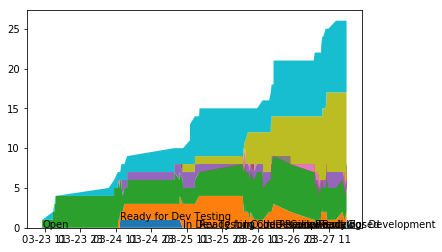

In [47]:
def cfd(transitions):
    y = {}
    x = []
    states = transitions['to'].append(transitions['from']).unique()
    for state in states:    
        if state is not None:
            y[state] = []
            
    for _, transition in transitions.sort_values(by=['ts'], ascending=True).iterrows():   
        if transition['to'] != transition['from']:
            x.append(pd.to_datetime(transition['ts']))
            for state in states:
                if state is not None:
                    last_value = 0 if not y[state] else y[state][-1]
                    if state == transition['from']:
                        y[state].append(last_value - 1)
                    elif state == transition['to']:
                        y[state].append(last_value + 1)
                    else: 
                        y[state].append(last_value)
    y['ts'] = x
    return DataFrame(y)

cfd = cfd(transitions)
fig, ax = plt.subplots()
columns = cfd.drop('ts',1).columns.sort_values(ascending=False)
x = cfd['ts'].values
y = []

area_labels=[]
for column in columns:
    y.append(cfd[column])
    area_labels.append(column)


stack = 0
for index, item in enumerate(y):
    max_index = y[index].argmax()
    date_peak = x[max_index]
    
    quartile = 1/(index+1)
    
    ax.text(date_peak, y[index][max_index]* quartile, area_labels[index])
    stack += y[index][max_index]

ax.stackplot(x, y)


#loc = y2.argmax()
#ax.text(loc, y1[loc] + y2[loc]*0.33, areaLabels[1])

#loc = y3.argmax()
#ax.text(loc, y1[loc] + y2[loc] + y3[loc]*0.75, areaLabels[2]) 

plt.show()


## WIP
* How many issues currently is in board

In [48]:
def wip(transitions):
    current_wip = 0
    wips = []
    for _, transition in transitions.sort_values(by=['key', 'ts'], ascending=True).iterrows():        
        if transition['from'] == '0Backlog' and transition['to'] not in ('5Done', '4Rejected'):
            current_wip+=1
        elif transition['to'] in ('0Backlog', '5Done', '4Rejected') and transition['from'] not in ('0Backlog','5Done', '4Rejected', None):
            current_wip-=1
        wips.append({'ts': pd.to_datetime(transition['ts']), 'wip': current_wip})
    return pd.DataFrame(wips)
wip = wip(transitions).sort_values(by='ts', ascending=True)

(array([737507.45833333, 737507.95833333, 737508.45833333, 737508.95833333,
        737509.45833333, 737509.95833333, 737510.45833333, 737510.95833333,
        737511.45833333]), <a list of 9 Text xticklabel objects>)

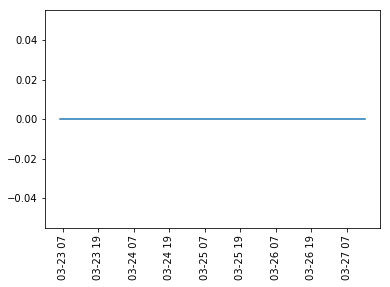

In [49]:
plt.plot(wip['ts'],wip['wip'])
plt.xticks(rotation='vertical')

In [50]:
wip.describe()

,wip
count,119.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0
